In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr


def pp_bahamas(ds):
    """Pre-processing of BAHAMAS datasets."""
    # Fix time coordinate
    ds = ds.rename({"tid": "time", "TIME": "time"}).set_index(time="time")

    # Add length of line-of-sight in m
    ds["LOS"] = ds.IRS_ALT / np.cos(np.radians(ds.IRS_THE)) / np.cos(np.radians(ds.IRS_PHI))

    return ds


def pp_radar(ds):
    """Pre-processing of Radar datasets."""
    # Fix time coordinate
    datetime = np.datetime64("1970-01-01", "ns")
    datetime += ds.time.values * np.timedelta64(1, "s")
    datetime += ds.microsec.values * np.timedelta64(1, "us")

    ds["time"] = datetime
    ds = ds.drop_vars("microsec")

    # Add reflectivity in dB
    ds = ds.assign(dBZg=lambda dx: 10 * np.log10(dx.Zg))
    
    return ds


def pp_radiometer(ds):
    return ds.rename(
        number_frequencies="frequency",
    ).set_index(
        frequency="frequencies",
    ).coarsen(
        time=4,
        boundary="pad",
    ).mean(
        "time"
    )


def correct_radar_height(ds_radar, ds_bahamas):
    """Correct radar range gates with HALO flight altitude."""
    flight_altitude = ds_bahamas.sel(time=ds_radar.time, method="nearest").LOS
    flight_altitude["time"] = ds_radar.time
    
    ds_height = ds_radar.sel(range=flight_altitude - ds_radar.range, method="nearest")
    ds_height["range"] = ds_radar.range

    return ds_height

In [2]:
bahamas = xr.open_dataset("/work/mh0010/EUREC4A/HALO/20200218/BAHAMAS/EUREC4A_HALO_BAHAMAS-QL-10Hz_20200218a.nc").pipe(pp_bahamas)
radar = xr.open_dataset("/work/mh0010/EUREC4A/HALO/20200218/Radar/20200218_1013_uncalib_prelim.nc").pipe(pp_radar)

In [3]:
radar

<xarray.Dataset>
Dimensions:          (range: 573, time: 25103)
Coordinates:
  * range            (range) float32 155.9 187.1 218.3 ... 1.796e+04 1.799e+04
  * time             (time) datetime64[ns] 2020-02-18T10:13:50.802739 ... 202...
Data variables: (12/49)
    nfft             int32 ...
    prf              int32 ...
    NyquistVelocity  float32 ...
    nave             int32 ...
    zrg              int32 ...
    rg0              int32 ...
    ...               ...
    MRMcx            (time) float32 ...
    RadarConst       (time) float32 ...
    SNRCorFaCo       (time, range) float32 ...
    SNRCorFaCx       (time, range) float32 ...
    SKWg             (time, range) float32 ...
    dBZg             (time, range) float32 nan nan nan nan ... nan nan nan nan
Attributes: (12/15)
    convention:        CF-1.0
    location:          Oberpfaffenhofen
    Altitude:          580m
    Latitude:          48°5'12.250"N
    Longitude:         11°16'47.250"E
    system:            HAXC
    ...                ...
    reference:         Ka Band Cloud Radar MIRA, METEK GmbH www.metek.de
    ppar:              PRF:        7500\nPDR:         208\nSFT:         256\n...
    hrd:               NAME:200218_101349.pds\nOPER:Tue Feb 18 10:13:49 2020\...
    Copywright:        
    Copywright_Owner:  
    notes:             It is accounted for the Receiver Bwd Loss in Radarcons...

Text(0, 0.5, 'Height / m')

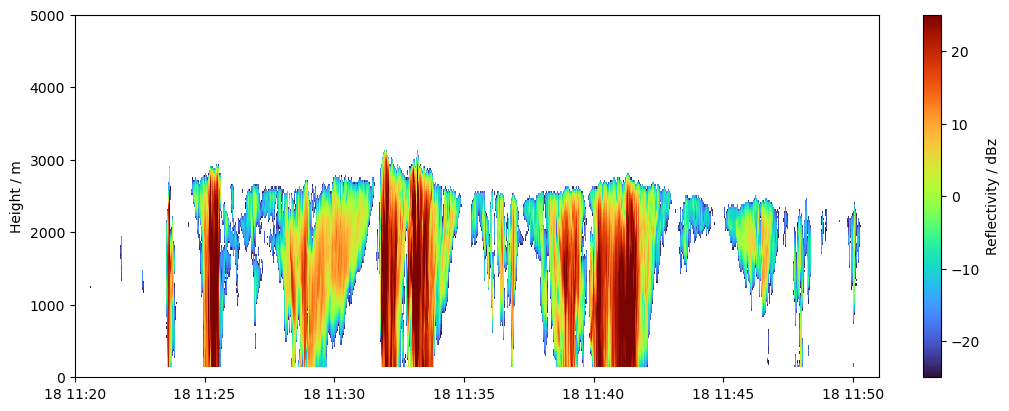

In [4]:
ds_height = correct_radar_height(radar, bahamas).sel(time=slice("2020-02-18 11:20", "2020-02-18 11:50"))

fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)
sm = ax.pcolormesh(
    ds_height.time,
    ds_height.range,
    ds_height.dBZg.where(ds_height.dBZg > -25).T,
    cmap="turbo",
    vmin=-25,
    vmax=25,
)
cb = fig.colorbar(sm, label="Reflectivity / dBz")
ax.set_ylim(0, 5_000)
ax.set_ylabel("Height / m")

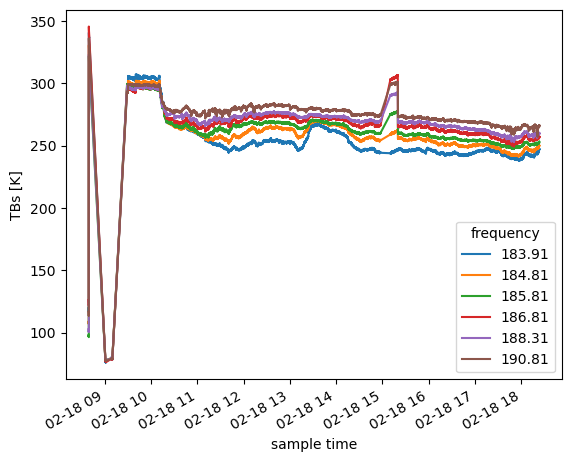

In [4]:
radiometer = xr.open_mfdataset("/work/mh0010/EUREC4A/HALO/20200218/radiometer/183/200218.BRT.NC").pipe(pp_radiometer)
radiometer.TBs.plot.line(x="time")